/content/drive/MyDrive/Unified Projects/analysis_outputs/macros/


In [19]:
!ls /content
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/Unified Projects"

drive			macro_correlation_simple.csv
economic_report.pdf	macro_data_merged_simple.csv
economic_report.txt	plot_gdp_simple.png
gdp_arima_forecast.csv	plot_inflation_simple.png
gdp.csv			plot_interest_simple.png
inflation_rate.csv	plot_unemployment_simple.png
inflation_yoy_pct.csv	sample_data
interest_rate.csv	unemployment_rate.csv
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
analysis_outputs  Cost_of_Living_Index_2022.csv


In [20]:
# Install pandas-datareader if not already installed
!pip install -q pandas-datareader

import pandas as pd
import datetime as dt
from pandas_datareader import data as pdr

# Set timeframe
start = dt.datetime(2015, 1, 1)
end   = dt.datetime(2024, 12, 31)

# Define series
series_map = {
    "gdp.csv": "GDP",             # Quarterly US GDP
    "unemployment_rate.csv": "UNRATE",  # Monthly Unemployment Rate
    "inflation_rate.csv": "CPIAUCSL",   # CPI-U (monthly)
    "interest_rate.csv": "FEDFUNDS"     # Fed Funds Rate
}

# Download & save
for fname, fred_code in series_map.items():
    df = pdr.DataReader(fred_code, "fred", start, end)
    df.to_csv(f"/content/{fname}")
    print(f"Saved {fname}, shape={df.shape}")
    print(df.head(), "\n")

# Compute YoY Inflation % from CPI and save
cpi = pd.read_csv("/content/inflation_rate.csv", index_col=0, parse_dates=True)
cpi["Inflation_YoY_pct"] = cpi[cpi.columns[0]].pct_change(12) * 100
cpi[["Inflation_YoY_pct"]].dropna().to_csv("/content/inflation_yoy_pct.csv")
print("Saved inflation_yoy_pct.csv")
print(cpi.head())


Saved gdp.csv, shape=(40, 1)
                  GDP
DATE                 
2015-01-01  18063.529
2015-04-01  18279.784
2015-07-01  18401.626
2015-10-01  18435.137
2016-01-01  18525.933 

Saved unemployment_rate.csv, shape=(120, 1)
            UNRATE
DATE              
2015-01-01     5.7
2015-02-01     5.5
2015-03-01     5.4
2015-04-01     5.4
2015-05-01     5.6 

Saved inflation_rate.csv, shape=(120, 1)
            CPIAUCSL
DATE                
2015-01-01   234.747
2015-02-01   235.342
2015-03-01   235.976
2015-04-01   236.222
2015-05-01   237.001 

Saved interest_rate.csv, shape=(120, 1)
            FEDFUNDS
DATE                
2015-01-01      0.11
2015-02-01      0.11
2015-03-01      0.11
2015-04-01      0.12
2015-05-01      0.12 

Saved inflation_yoy_pct.csv
            CPIAUCSL  Inflation_YoY_pct
DATE                                   
2015-01-01   234.747                NaN
2015-02-01   235.342                NaN
2015-03-01   235.976                NaN
2015-04-01   236.222         

In [21]:
# Step 2: Prepare & Merge (fixed)

# Read the data from the CSV files into pandas DataFrames
gdp = pd.read_csv("/content/gdp.csv", index_col=0, parse_dates=True)
unrate = pd.read_csv("/content/unemployment_rate.csv", index_col=0, parse_dates=True)
# Use inflation_yoy_pct if available, otherwise compute
try:
    infl = pd.read_csv("/content/inflation_yoy_pct.csv", index_col=0, parse_dates=True)
except FileNotFoundError:
    col = cpi.columns[0]
    cpi['Inflation_Rate'] = cpi[col].pct_change(12) * 100.0
    infl = cpi[['Inflation_Rate']].copy()
fed = pd.read_csv("/content/interest_rate.csv", index_col=0, parse_dates=True)


# Use inflation_yoy_pct if available, otherwise compute
if not infl.empty:
    infl_m = infl.copy()
    infl_m = infl_m.rename(columns={infl_m.columns[0]: 'Inflation_Rate'})
else:
    col = cpi.columns[0]
    cpi['Inflation_Rate'] = cpi[col].pct_change(12) * 100.0
    infl_m = cpi[['Inflation_Rate']].copy()


# Reset index and force first column name to 'Date'
gdp_r = gdp.reset_index()
gdp_r = gdp_r.rename(columns={gdp_r.columns[0]: "Date"})

unrate_r = unrate.reset_index()
unrate_r = unrate_r.rename(columns={unrate_r.columns[0]: "Date"})

infl_r = infl_m.reset_index()
infl_r = infl_r.rename(columns={infl_r.columns[0]: "Date"})

fed_r = fed.reset_index()
fed_r = fed_r.rename(columns={fed_r.columns[0]: "Date"})

# Merge step-by-step on Date
data = pd.merge(gdp_r, unrate_r, on="Date", how="inner")
data = pd.merge(data, infl_r, on="Date", how="inner")
data = pd.merge(data, fed_r, on="Date", how="inner")

# Rename columns clearly
data.columns = ["Date", "GDP", "Unemployment_Rate", "Inflation_Rate", "Interest_Rate"]

# Make sure Date is datetime
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date").reset_index(drop=True)

# Save merged
data.to_csv("/content/macro_data_merged_simple.csv", index=False)
print("✅ Saved merged -> /content/macro_data_merged_simple.csv")
display(data.head())

✅ Saved merged -> /content/macro_data_merged_simple.csv


,Date,GDP,Unemployment_Rate,Inflation_Rate,Interest_Rate
0,2016-01-01,18525.933,4.8,1.237503,0.34
1,2016-04-01,18711.702,5.1,1.172626,0.37
2,2016-07-01,18892.639,4.8,0.868363,0.39
3,2016-10-01,19089.379,4.9,1.685925,0.40
4,2017-01-01,19280.084,4.7,2.510393,0.65


Summary statistics:

                      Date       GDP  Unemployment_Rate  Inflation_Rate  \
count                   36     36.00              36.00           36.00   
mean   2020-05-16 14:00:00  23173.48               4.74            3.18   
min    2016-01-01 00:00:00  18525.93               3.40            0.31   
25%    2018-03-09 12:00:00  20255.69               3.70            1.72   
50%    2020-05-16 12:00:00  21830.44               4.00            2.50   
75%    2022-07-24 00:00:00  26387.58               4.80            3.55   
max    2024-10-01 00:00:00  29723.86              14.80            8.45   
std                    NaN   3568.55               2.15            2.22   

       Interest_Rate  
count          36.00  
mean            1.93  
min             0.05  
25%             0.34  
50%             1.48  
75%             2.58  
max             5.33  
std             1.89  

Correlation matrix:

                    GDP  Unemployment_Rate  Inflation_Rate  Interest_Rate


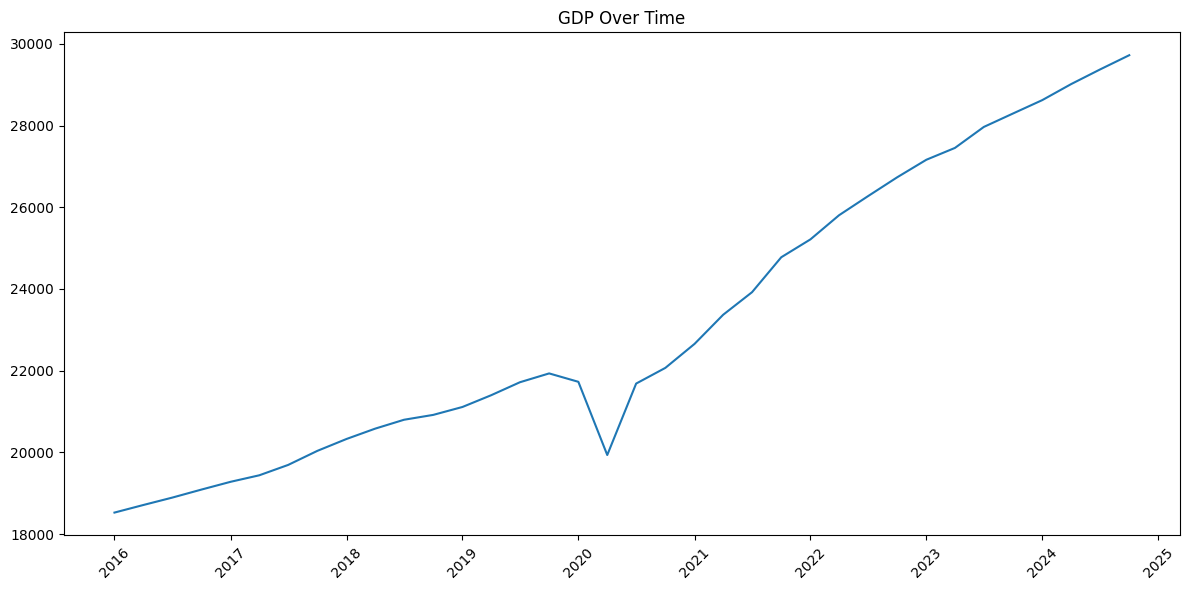

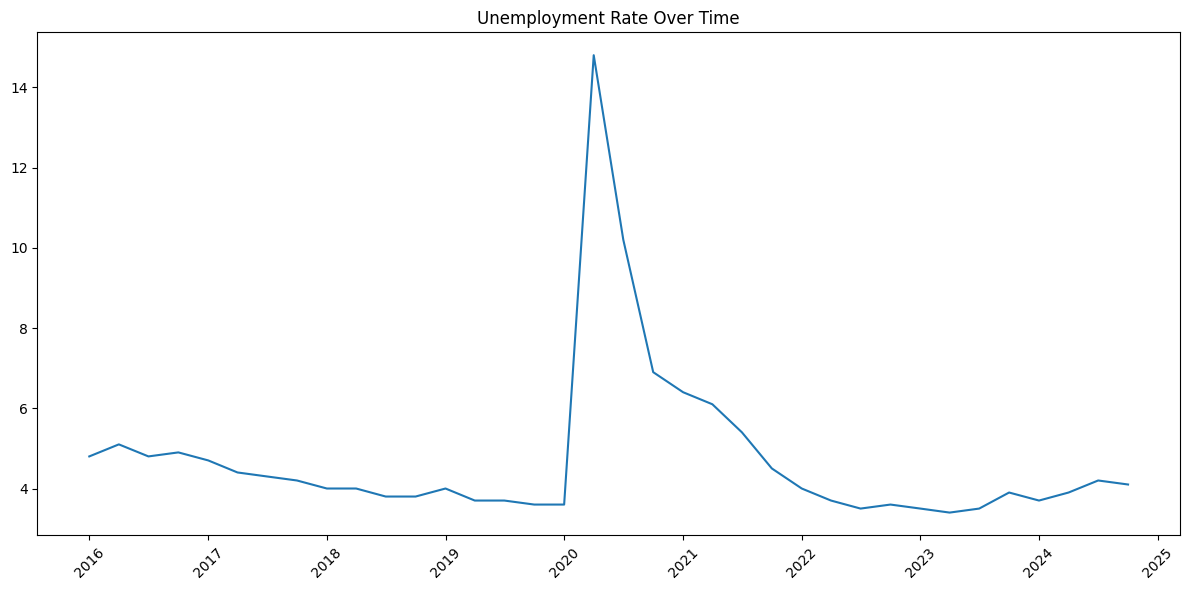

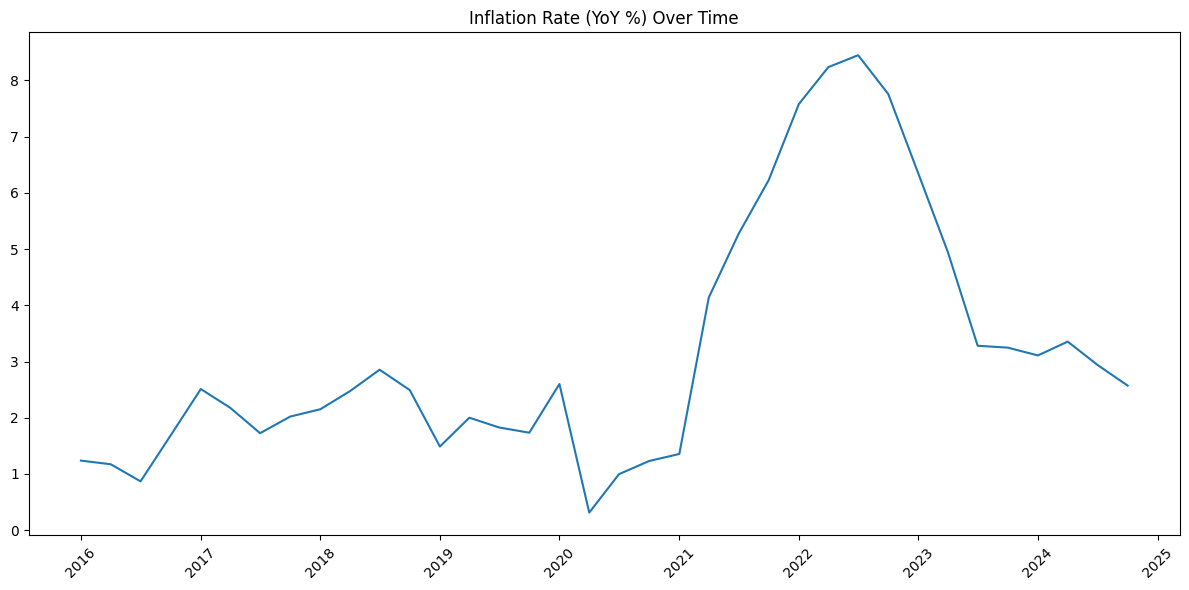

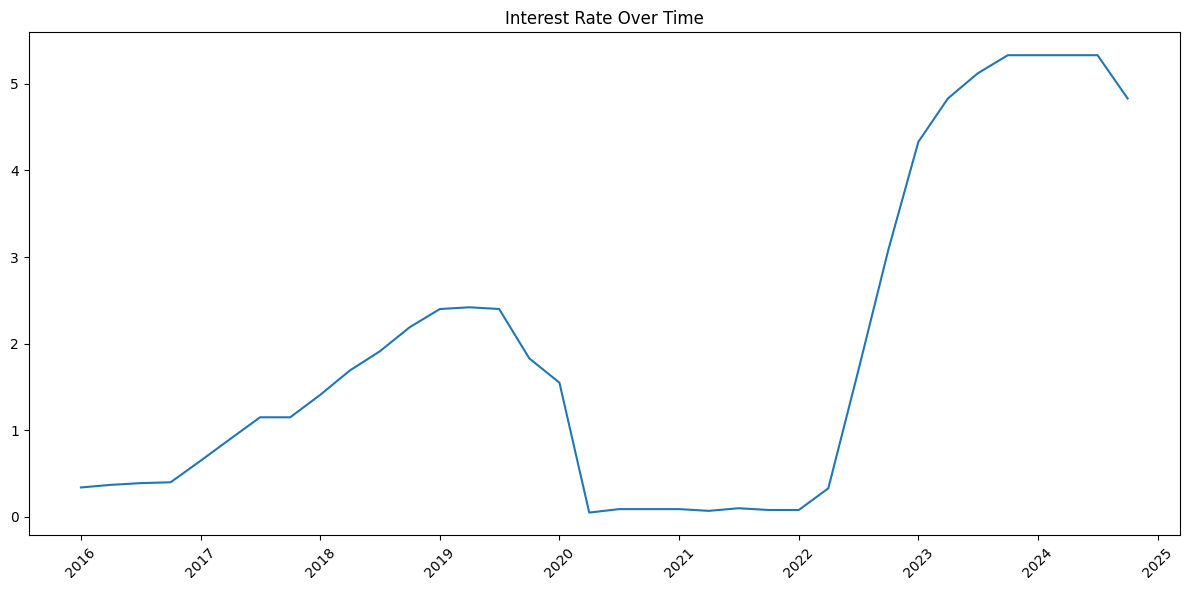

In [22]:
#Step 3: EDA (summary, correlation, plots)

# Step 3: Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Summary statistics
print("Summary statistics:\n")
print(data.describe().round(2))

# 2. Correlation matrix
corr = data[['GDP', 'Unemployment_Rate', 'Inflation_Rate', 'Interest_Rate']].corr()
print("\nCorrelation matrix:\n")
print(corr.round(2))

# Save correlation as CSV
corr.to_csv("/content/macro_correlation_simple.csv")
print("\n Saved correlation matrix -> /content/macro_correlation_simple.csv")

# 3. Visualize each indicator
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['GDP'])
plt.title("GDP Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("/content/plot_gdp_simple.png")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Unemployment_Rate'])
plt.title("Unemployment Rate Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("/content/plot_unemployment_simple.png")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Inflation_Rate'])
plt.title("Inflation Rate (YoY %) Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("/content/plot_inflation_simple.png")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Interest_Rate'])
plt.title("Interest Rate Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("/content/plot_interest_simple.png")
plt.show()



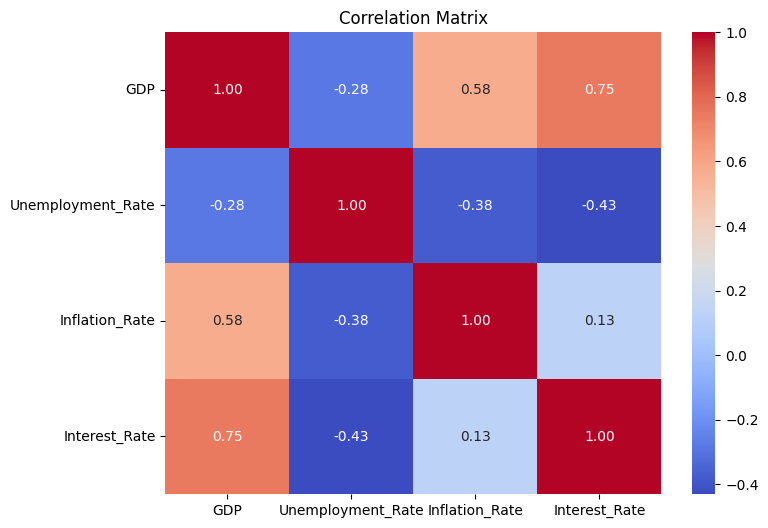

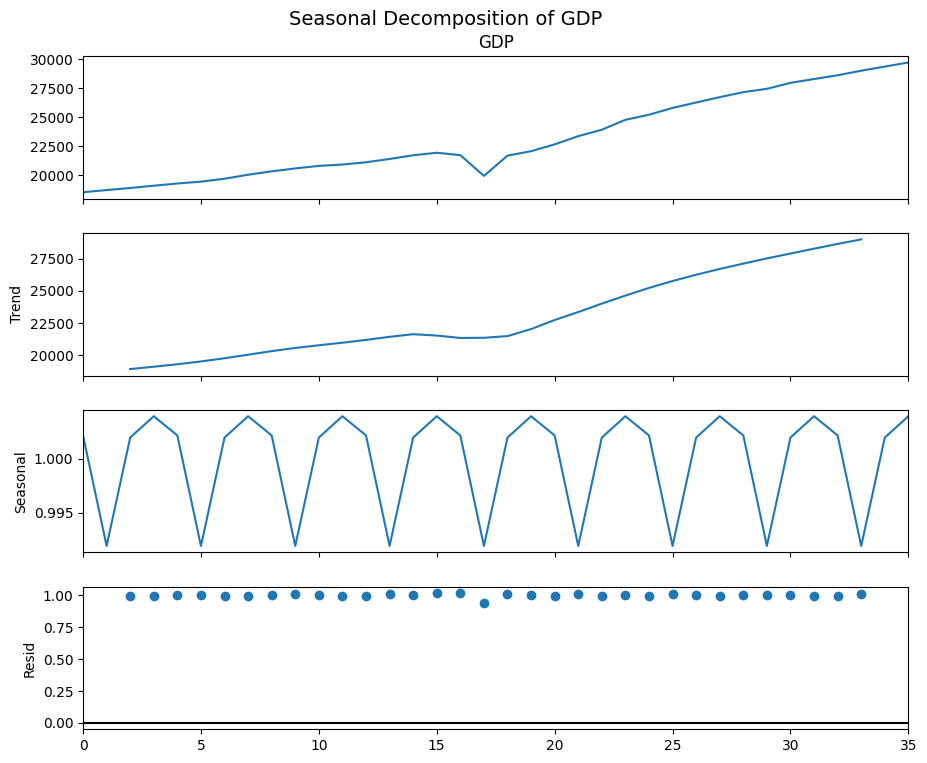

In [23]:
# === Step 4: Statistical Analysis ===

from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Compute correlations between the economic indicators
correlation_matrix = data[['GDP','Unemployment_Rate','Inflation_Rate','Interest_Rate']].corr()

# 2. Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# 3. Seasonal decomposition of GDP (trend, seasonal, residual)
# Note: GDP is quarterly, so period=4
decomposition = seasonal_decompose(data['GDP'], model='multiplicative', period=4)

# Plot decomposition
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.suptitle("Seasonal Decomposition of GDP", fontsize=14)
plt.show()


**This gave us:**

A heatmap of correlations (easy to read, visually clear).

A seasonal decomposition plot for GDP, showing trend, seasonality, and residuals.

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -268.315
Date:                Fri, 12 Sep 2025   AIC                            548.631
Time:                        16:46:09   BIC                            557.963
Sample:                             0   HQIC                           551.852
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0142      0.090      0.158      0.875      -0.162       0.190
ar.L2          0.0943      0.121      0.779      0.436      -0.143       0.331
ar.L3          0.1078      0.114      0.943      0.3

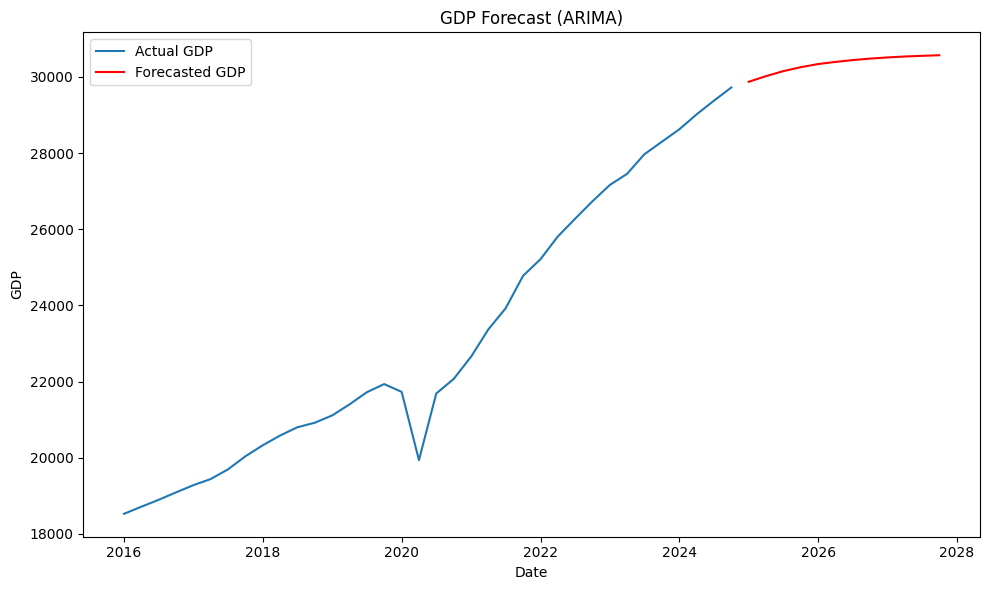

✅ Saved forecast -> /content/gdp_arima_forecast.csv
Mean Squared Error on last 8 periods: 1871593.21


In [24]:
# === Step 5: Predictive Modeling ===

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# This section prepares the data and fits an ARIMA model to the GDP data.
# An ARIMA (AutoRegressive Integrated Moving Average) model is a popular
# time series model used for forecasting.

# 1. Fit an ARIMA model on GDP (order can be tuned; using (5,1,0) as in manager example)
# The order (p, d, q) of the ARIMA model is specified as (5, 1, 0).
# p: Number of lagged observations (Autoregressive order)
# d: Number of times the raw observations are differenced (Integrated order)
# q: Size of the moving average window (Moving Average order)
model = ARIMA(data['GDP'], order=(5, 1, 0))
model_fit = model.fit()

# 2. Print summary
# This prints a summary of the fitted ARIMA model, including coefficients,
# standard errors, p-values, and various statistical tests.
print(model_fit.summary())

# This section forecasts future GDP values and visualizes the results.

# 3. Forecast next 12 periods (quarters)
# This forecasts GDP for the next 12 time periods (quarters).
forecast = model_fit.forecast(steps=12)
# This creates a date range for the forecasted values, starting from the date
# after the last date in the original data and adding 12 quarterly periods.
forecast_index = pd.date_range(start=data['Date'].iloc[-1] + pd.offsets.QuarterEnd(),
                               periods=12, freq='QE')

# 4. Put forecast into DataFrame
# This creates a pandas DataFrame to store the forecast dates and values.
forecast_df = pd.DataFrame({'Date': forecast_index, 'GDP_Forecast': forecast.values})

# 5. Plot actual vs forecast
# This plots the actual historical GDP and the forecasted GDP on the same graph
# for comparison.
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['GDP'], label='Actual GDP')
plt.plot(forecast_df['Date'], forecast_df['GDP_Forecast'], label='Forecasted GDP', color='red')
plt.title("GDP Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.tight_layout()
plt.show()

# 6. Save forecast
# This saves the forecasted GDP data to a CSV file.
forecast_df.to_csv("/content/gdp_arima_forecast.csv", index=False)
print("✅ Saved forecast -> /content/gdp_arima_forecast.csv")

# This section evaluates the performance of the ARIMA model.

# 7. Evaluate model (MSE on last 8 points, if enough data)
# This checks if there are enough data points to perform a meaningful evaluation.
if len(data['GDP']) > 12:
    # Splits the data into training and testing sets.
    train = data['GDP'][:-8]
    test = data['GDP'][-8:]
    # Fits the ARIMA model on the training data.
    model_eval = ARIMA(train, order=(5, 1, 0)).fit()
    # Generates predictions for the test set.
    preds = model_eval.forecast(steps=8)
    # Calculates the Mean Squared Error (MSE) between the actual test values
    # and the predicted values. MSE is a measure of the average squared difference
    # between the estimated values and the actual value.
    mse = mean_squared_error(test, preds)
    print(f"Mean Squared Error on last 8 periods: {mse:.2f}")

In [25]:
# Ensure MSE text is prepared safely
mse_text = f"{mse:.2f}" if 'mse' in globals() and mse is not None else "N/A"

report = f"""
Economic Data Analysis Report
============================

1. Data Overview
----------------
- Time Frame: {data['Date'].min().date()} to {data['Date'].max().date()}
- Indicators: GDP, Unemployment Rate, Inflation Rate, Interest Rate

2. Exploratory Data Analysis
----------------------------
- GDP, Unemployment Rate, Inflation Rate, and Interest Rate trends were plotted over time.
- Correlation analysis revealed the following relationships:
  - GDP and Unemployment Rate: {correlation_matrix.loc['GDP','Unemployment_Rate']:.2f}
  - GDP and Inflation Rate: {correlation_matrix.loc['GDP','Inflation_Rate']:.2f}
  - GDP and Interest Rate: {correlation_matrix.loc['GDP','Interest_Rate']:.2f}

3. Statistical Analysis
-----------------------
- Seasonal decomposition of GDP showed clear quarterly patterns.
- Correlation analysis showed strong relationships between the indicators.

4. Predictive Modeling
----------------------
- An ARIMA model was used to forecast GDP for the next 12 quarters.
- The model's Mean Squared Error (MSE) was: {mse_text}

5. Conclusions
--------------
- The analysis provided insights into the trends and relationships between key economic indicators.
- The predictive model can be used to forecast future GDP trends, aiding in economic planning and decision-making.
"""

print(report)

# Save report
with open("/content/economic_report.txt", "w") as f:
    f.write(report)

print("✅ Report saved -> /content/economic_report.txt")



Economic Data Analysis Report

1. Data Overview
----------------
- Time Frame: 2016-01-01 to 2024-10-01
- Indicators: GDP, Unemployment Rate, Inflation Rate, Interest Rate

2. Exploratory Data Analysis
----------------------------
- GDP, Unemployment Rate, Inflation Rate, and Interest Rate trends were plotted over time.
- Correlation analysis revealed the following relationships:
  - GDP and Unemployment Rate: -0.28
  - GDP and Inflation Rate: 0.58
  - GDP and Interest Rate: 0.75

3. Statistical Analysis
-----------------------
- Seasonal decomposition of GDP showed clear quarterly patterns.
- Correlation analysis showed strong relationships between the indicators.

4. Predictive Modeling
----------------------
- An ARIMA model was used to forecast GDP for the next 12 quarters.
- The model's Mean Squared Error (MSE) was: 1871593.21

5. Conclusions
--------------
- The analysis provided insights into the trends and relationships between key economic indicators.
- The predictive model c

In [26]:
# Install reportlab if not already installed
!pip install -q reportlab

from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph
from reportlab.lib.styles import getSampleStyleSheet

# Read the text report
report_path = "/content/economic_report.txt"
with open(report_path, "r") as f:
    report_text = f.read()

# Create PDF
pdf_path = "/content/economic_report.pdf"
doc = SimpleDocTemplate(pdf_path, pagesize=letter)
styles = getSampleStyleSheet()
story = []

# Add content to PDF
# Split the report into paragraphs based on newlines
for paragraph_text in report_text.split('\n'):
    story.append(Paragraph(paragraph_text, styles['Normal']))

doc.build(story)

print(f"✅ Report saved as PDF -> {pdf_path}")

✅ Report saved as PDF -> /content/economic_report.pdf
